# VOIE Order Completion & Revenue Optimization Model

In [3]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

# VOIE Order Success Model

The function below, `success`, models VOIE Order Completion metrics based on the given inputs. The input and output documentation is below. The function is designed to demonstrate how **changes** in the VOIE workflow metrics can affect VOIE KPIs and revenue (i.e. how decreasing fallout at certain points in the workflow can impact revenue). The model is built off of set constants are based off of recent metrics to provide a "baseline" or ***usual*** fallout amount between workflow points. This will help us simulate the impact of metric and order changes on revenue.

### Function Inputs: 

- `inc_total_VOIE`: Amount to increase VOIE orders by (raw #)
- `inc_interact_rate`: Amount to increase Interaction Rate by (%, should be between 0 & 1)
- `inc_attempt_rate`: Amount to increase Login Attempt Rate by (%, should be between 0 & 1)
- `inc_complete_rate`: Amount to increase Completed Login Rate by (%, should be between 0 & 1)
- `labels`: Whether you want labels in your output (Binary variable, 1 provides labels & 0 doesn't)

### Function Outputs: 

- `VOIEs Started`: Total number of VOIE orders started.
- `VOIEs Completed`: Total number of VOIE orders completed.
- `Pullthrough`: The % of VOIE orders that are completed out of those that are interacted with.
- `Borrower Conversion`: The % of VOIE orders that are completed out of the total VOIEs Started (includes those that are not interacted with).
- `Revenue`: Total Revenue.

### NOTE: The model is produced based on baseline metrics from the month of March 2022. Each change/increase put into the model will be based on the March metrics as a starting point.

In [6]:
def success(inc_total_VOIE, inc_interact_rate, inc_attempt_rate, inc_complete_rate, labels):
    
    total_voie = 7441 + inc_total_VOIE
    num_interact = total_voie * (0.476 + inc_interact_rate)
    num_attempt = num_interact * (0.761 + inc_attempt_rate)
    num_complete = num_attempt * (0.329 + inc_complete_rate)
    num_complete = int(num_complete)

    pullthrough = str(round((num_complete*100) / num_interact, 0))+'%'
    borrower_conversion = str(round((num_complete*100) / total_voie, 0))+'%'
    revenue = round(15*num_complete, 2)
    
    if labels == 1:
        total_voie2 = 'VOIEs Started: ' + str(total_voie)
        num_complete2 = 'VOIEs Completed: ' + str(round(int(num_complete), 0))
        pullthrough = 'Pullthrough: ' + str(round((num_complete*100) / num_interact, 0))+'%'
        borrower_conversion = 'Borrower Conversion: ' + str(round((num_complete*100) / total_voie, 0))+'%'
        revenue = 'Revenue: $' + str(round(15*num_complete, 2))
        
        return total_voie2, num_complete2, pullthrough, borrower_conversion, revenue
    
    elif labels == 0:
        return total_voie, num_complete, pullthrough, borrower_conversion, revenue
    
    else:
        return 'Error: Must put 0 or 1 into the labels argument'

## The Math behind the Madness:

These equations together are a system of equations that have one solution because they are not linearly dependent. In non-math speak: none of the equations are scalar multiples of each other (i.e. the same equation multiplied by a constant), so we know they have a solution. The Cs are unknown constants, or in other words, the function inputs that the user decides to simulate in the model. The set constants are based off of recent metrics to provide a "baseline" or ***usual*** fallout amount between workflow points. 

### System of Equations:

####    w = 7441 + Cw
####   x = w * (0.476 + Cx)
####   y = x * (0.761 + Cy)
####   z = y * (0.329 + Cz)


The intercept point between these lines is the solution to the system of equations and represents the raw numbers in our model: w = Total VOIEs Orders, x = Number Interacted, y = Number Attempted Login, z = Number Completed Login. We can then use these raw counts to model revenue, pullthrough, and conversion.

### Solution for baseline (no changes/increases from baseline/March):

#### w = 7441

#### x = 885479 / 250 = 3542

#### y = (761 * 3542) / 1000 = 2695

#### z = (329 * 2695) / 1000 = 887

## Baseline vs. Increase Model Comparison 

Below, we define the `baseline_model` (all increase amounts set to 0) and the `increase_model`. Any change in values can be input into the `increase_model`, and the changes will be reflected in the Data Frame. Tip: Leave the labels argument set to 0 in the `increase_model` for best readability.

In [7]:
#baseline defined by setting all changes to 0. The coefficients are based on March metrics.
baseline = success(0,0,0,0,0)

#Edit model below by inputing increase amounts as defined in the inputs section above^:
increase_model = success(1000,.05,.05,.05,0)
     
model_data = pd.DataFrame([baseline, increase_model], columns = ['Total VOIEs', 'Completed VOIEs', 'Pullthrough', 'Borrower Conversion', 'Revenue'])
row_headers = ['Baseline', 'Model (based on inputs)']
model_data.index = row_headers

model_data

,Total VOIEs,Completed VOIEs,Pullthrough,Borrower Conversion,Revenue
Baseline,7441,886,25.0%,12.0%,13290
Model (based on inputs),8441,1364,31.0%,16.0%,20460


## Isolated Variable Impact on Revenue

Below, isolated revenue impacts are created for each input by increasing the metric by 1% and holding all of the inputs constant (setting the rest all to 0). This will model the amount of revenue that will be created with a 1% increase in that metric with all other variables held constant.

The second chunk of code below calculates the difference from the baseline revenue (i.e. what is the impact or change in revenue from the 1% change in that variable?).

A Data Frame is produced to provide a comparison of the `Isolated Impact from 1% Increase` to the `Baseline Revenue`.

In [8]:
#Isolated revenue impacts are created, all other inputs held constant (set to 0).
baseline_rev = success(0,0,0,0,0)[4]
oneperc_voie_rev = success(74,0,0,0,0)[4]
oneperc_interaction_rev = success(0,0.01,0,0,0)[4]
oneperc_attempted_rev = success(0,0,.01,0,0)[4]
oneperc_completed_rev = success(0,0,0,.01,0)[4]

#Difference of isolated variable revenues from baseline revenue
Diff_baseline = 0
Diff_baseline_voie = oneperc_voie_rev - baseline_rev
Diff_baseline_interaction = oneperc_interaction_rev - baseline_rev
Diff_baseline_attempted = oneperc_attempted_rev - baseline_rev
Diff_baseline_completed = oneperc_completed_rev - baseline_rev

isolated_list = [baseline_rev, oneperc_voie_rev, oneperc_interaction_rev, oneperc_attempted_rev, oneperc_completed_rev]
Diffs_list = [Diff_baseline, Diff_baseline_voie, Diff_baseline_interaction, Diff_baseline_attempted, Diff_baseline_completed]
array = np.array([isolated_list, Diffs_list])

cols = ['Estimated Revenue', 'Difference from Baseline / Isolated Impact from 1% increase']
rows = ['Baseline Revenue', '1% inc Total VOIEs', '1% inc Interaction', '1% inc Attempted Login', '1% Increase Completed Login']
#isolated_metricsdf = pd.DataFrame(array, columns = col)


#isolated_metricsdf.index = row_headers
#isolated_metricsdf

zips = zip(isolated_list, Diffs_list)
#next(zips)

isolated_metricsdf = pd.DataFrame(zips, columns = cols)
isolated_metricsdf.index = rows
isolated_metricsdf

,Estimated Revenue,Difference from Baseline / Isolated Impact from 1% increase
Baseline Revenue,13290,0
1% inc Total VOIEs,13425,135
1% inc Interaction,13575,285
1% inc Attempted Login,13470,180
1% Increase Completed Login,13695,405


## Visualizing the differences in revenue:

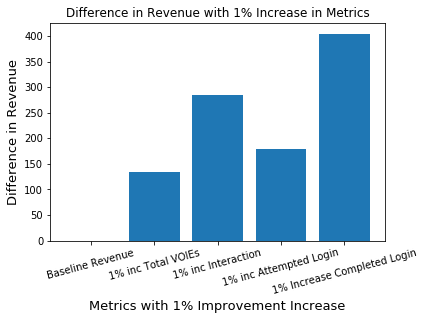

In [9]:
bar = plt.bar(rows, Diffs_list)
plt.xticks(rotation=15)
plt.ylabel('Difference in Revenue', fontsize = 13)
plt.xlabel('Metrics with 1% Improvement Increase', fontsize = 13)
plt.title('Difference in Revenue with 1% Increase in Metrics')
plt.show()

### Therefore, increasing completed logins by 1% will have the biggest increase in revenue (~$400) out of all the other metrics. 

## Exploratory: Testing Hypothetical Situations

The function below, `hypotheticals`, takes the raw inputs (not increases like above) for `total_voie`, `interact_rate`, `attempt_rate`, and `complete_rate`. I modeled a few hypothetical situations to explore the effect on revenue:

1. Baseline
2. How many VOIE orders started we need for $50,000 in revenue with all other metrics held constant
3. A 5% increase in interaction rate, all else constant
4. A 5% increase in VOIE orders started and all metrics
5. A 5% increase in all metrics and increase in VOIE orders by 50%
6. Double VOIE orders started and 10% increase in interaction

A table is produced below to explore the revenue outcomes for these situations.

In [10]:
#takes raw input #s (not icreases) and outputs metrics and revenue
def hypotheticals(total_voie, interact_rate, attempt_rate, complete_rate):
    
    total_voie2 = str(total_voie)
    num_interact = total_voie*interact_rate
    num_attempt = num_interact*attempt_rate
    num_complete = int(round(num_attempt*complete_rate, 0))
    
    pullthrough = str(round((num_complete*100) / num_interact, 0))+'%'
    borrower_conversion = str(round((num_complete*100) / total_voie, 0))+'%'
    revenue = '$' + str(15*num_complete)

    return total_voie2, num_complete, pullthrough, borrower_conversion, revenue

In [18]:
row_headers = ['Baseline', 'How to reach $50K by inc. orders, all else constant','5% increase in all metrics','5% increase in all metrics, 50% more VOIE orders', '5% increase in interaction', '10% inc interaction, 15,000 orders']

#baseline created w/ recent metrics
baseline = hypotheticals(7441, .476, .76, .33)
baseline

#how to raise rev to $50K with all else constant
fifty_k = hypotheticals(27930, .476, .76, .33)
fifty_k

#Raise interaction rate by 5%
five_perc_inc_interact = hypotheticals(7441, .526, .76, .33)
five_perc_inc_interact

#Raise all metrics and VOIE orders by 5%
five_perc_inc_all = hypotheticals(7813, .526, .81, .38)
five_perc_inc_all

#Raise all metrics 5% and VOIE orders by 50%
five_perc_inc_all_50_perc_more_voie = hypotheticals(11720, .526, .81, .38)
five_perc_inc_all_50_perc_more_voie

#Raise interaction by 10% and double VOIE order volume
inc_interact_double_orders = hypotheticals(15000, .576, .76, .33)
inc_interact_double_orders

List = [baseline, fifty_k, five_perc_inc_all, five_perc_inc_all_50_perc_more_voie, five_perc_inc_interact, inc_interact_double_orders]

hypothetical_table = pd.DataFrame(List, columns = ['Total VOIEs', 'Completed VOIEs', 'Pullthrough', 'Borrower Conversion', 'Revenue']) 

hypothetical_table.index = row_headers

hypothetical_table.set_title('d')

,Total VOIEs,Completed VOIEs,Pullthrough,Borrower Conversion,Revenue
Baseline,7441,888,25.0%,12.0%,$13320
"How to reach $50K by inc. orders, all else constant",27930,3334,25.0%,12.0%,$50010
5% increase in all metrics,7813,1265,31.0%,16.0%,$18975
"5% increase in all metrics, 50% more VOIE orders",11720,1898,31.0%,16.0%,$28470
5% increase in interaction,7441,982,25.0%,13.0%,$14730
"10% inc interaction, 15,000 orders",15000,2167,25.0%,14.0%,$32505


## Success Calculator for Experimenting

Takes the raw #s as inputs and produces an output with labels.

In [12]:
def success_calculator(total_voie, interact_rate, attempt_rate, complete_rate):
    
    total_voie2 = 'VOIEs Started: ' + str(total_voie)
    num_interact = total_voie*interact_rate
    num_attempt = num_interact*attempt_rate
    num_complete = int(round(num_attempt*complete_rate, 0))
    num_complete2 = 'VOIEs Completed: ' + str(num_complete)
    
    pullthrough = 'Pullthrough = ' + str(round((num_complete*100) / num_interact, 0))+'%'
    borrower_conversion = 'Borrower Conversion = ' + str(round((num_complete*100) / total_voie, 0))+'%'
    revenue = '$' + str(15*num_complete)

    return total_voie2, num_complete2, pullthrough, borrower_conversion, revenue